In [1]:
from json import load
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,Compose, Resize, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Auxiliary codes
- Detect GPU
- Load base
- Calculate metrics
- Evaluate model

In [2]:
def get_default_device():

    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]

    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

## Extracting Attention
### Model
- Dino 8 Patches Base - https://github.com/facebookresearch/dino

In [16]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_attention_matrix(model, img,sequential=False,patch = 8):

  device = get_default_device()
  model.to(device)
  model.blocks[-1].attn.qkv.register_forward_hook(get_activation('qkv'))

  transform = Compose([Resize(size=(224, 224)), ToTensor()])
  x = transform(img)
  x.size()
  x = x.cuda()
  logits = model(x.unsqueeze(0))
  att_mat = activation['qkv']
  input_expanded = activation['qkv'][0]


  qkv = input_expanded.reshape(785, 3, 12, 768//12)
  q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
  k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
  kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)

  attention_matrix = q @ kT
  
  return attention_matrix, img
  

In [32]:
import os
def extract_features(folder_path, save_path):
  dino8= torch.hub.load('facebookresearch/dino:main', 'dino_vitb8', pretrained=True)
  if not os.path.exists(folder_path):
    raise Exception("Folder path invalid or incorrect!")

  if not os.path.exists(save_path):
    try:
        os.makedirs(save_path)
    except:
        raise Exception("Save path not created, please check permission!")


  for file in os.listdir(folder_path):
    try:
      img = Image.open(file)
    except:
      raise Exception("Image file corrupted, please check file manually!")

    att_matrix, img = get_attention_matrix(dino8,img,sequential=True)
    np.savez(save_path+file.split('.')[0], att_matrix.cpu())



In [ ]:
folder_path = ""
save_path = ""
extract_features(folder_path, save_path)

## Attention Matrix Vizualization

['arr_0']


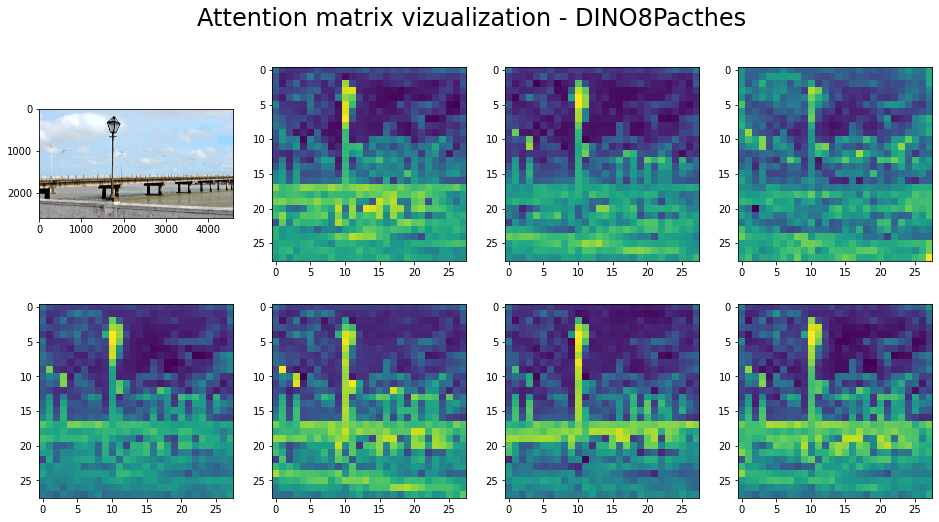

In [41]:
import matplotlib.pyplot as plt
import numpy as np


def att_matrix_vizualization(att_matrix, img):
  fig = plt.figure(figsize=(16, 8))
  fig.suptitle("Attention matrix vizualization - DINO8Pacthes", fontsize=24)
  fig.add_axes()
  img = np.asarray(img)
  ax = fig.add_subplot(2, 4, 1)
  ax.imshow(img)
  for i in range(5,12):  # visualize the 100th rows of attention matrices in the 0-7th heads
      attn_heatmap = att_matrix[i, -1, 1:].reshape((28, 28))
      ax = fig.add_subplot(2, 4, i-3)
      ax.imshow(attn_heatmap)

npz_file =  np.load('FSCN2928.npz')
img = Image.open('FSCN2928.JPG')
att_matrix_vizualization(npz_file['arr_0'], img)